In [161]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage 

In [162]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [163]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', google_api_key = os.getenv('GEMINI_KEY'))

In [164]:
tavily_tool = TavilySearchResults()

In [165]:
@tool
def get_city_details(prompt:str)->str:
    """Should do web search to finf the required details of the city"""
    response = tavily_tool.invoke(prompt)
    print(f'this is a tool call and resposne {response}')
    return response

In [166]:
tools = [get_city_details]

In [167]:
model_with_tools=  llm.bind_tools(tools)

In [168]:
class CityDetails(BaseModel):
    """Respond to user with this """
    state_name:str= Field(description="State name of the city")
    state_capital:str = Field(description="State captial of the city")
    country_name:str=Field(description="Country name of the city")
    country_capital:str=Field(description="Country capital of the city")

In [169]:
class AgentState(MessagesState):
    #structured resposne from the agent
    final_resposne:CityDetails

In [170]:
with_structure_output = llm.with_structured_output(CityDetails)

In [171]:
def call_model(state:AgentState):
    print(f'this is a input from call model {state}')
    response = model_with_tools.invoke(state['messages'])
    print(f'this is the resposne from callmodel {response}')
    return {"messages":[response]}

In [172]:
def should_continue(state:AgentState):
    messages = state['messages']
    last_messgaes = messages[-1]
   
    
    if not last_messgaes.tool_calls:
        return 'respond'
    else:
        return 'continue'

In [173]:
def respond(state:AgentState):
    print(f"this is a respond call {state}")
    response = with_structure_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    print(f'this is the response from resposnd {response}')
    return {"final_resposne": response}

In [174]:
workflow = StateGraph(AgentState)
workflow.add_node('llm', call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)

workflow.set_entry_point('llm')
workflow.add_conditional_edges(
    "llm",

    should_continue,
    {
        'continue':"tools",
        "respond":"respond"
    }
)
workflow.add_edge("tools", "llm")
workflow.add_edge('respond', END)
graph =workflow.compile()

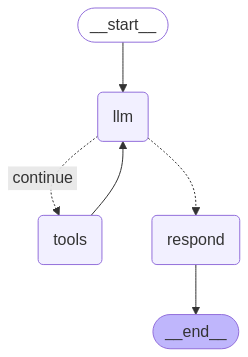

In [175]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [179]:
answer = graph.invoke(input={"messages": [("human", "tell me about mumbai")]})["final_resposne"]



this is a input from call model {'messages': [HumanMessage(content='tell me about mumbai', additional_kwargs={}, response_metadata={}, id='0c76a226-8985-456a-bb74-627487e038e5')]}
this is the resposne from callmodel content='' additional_kwargs={'function_call': {'name': 'get_city_details', 'arguments': '{"prompt": "Mumbai city details"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-5c3eb61e-8a54-4f7e-b2f2-99e9fa632a02-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Mumbai city details'}, 'id': '57ecf2e1-7819-4f0f-94ed-d2d77083891f', 'type': 'tool_call'}] usage_metadata={'input_tokens': 24, 'output_tokens': 9, 'total_tokens': 33, 'input_token_details': {'cache_read': 0}}
this is a tool call and resposne [{'title': 'Mumbai City district - Wikipedia', 'url': 'https://en.wikipedia.org/wiki/Mumbai_City_district', 'content': 'Mumbai City district is 

In [177]:
answer


CityDetails(state_name='Maharashtra', state_capital='Mumbai', country_name='India', country_capital='New Delhi')